In [53]:
import warnings
import numpy as np
import xarray as xr
import proplot as pplt
pplt.rc.reso='hi'
warnings.filterwarnings('ignore')

In [54]:
FILEDIR = '/ocean/projects/atm200007p/sferrett/Repos/monsoon-pr/data/processed'
SAVEDIR = '/ocean/projects/atm200007p/sferrett/Repos/monsoon-pr/figs'
REGIONS = {
    'Eastern Arabian Sea':{'latmin':9.,'latmax':19.5,'lonmin':64.,'lonmax':72.}, 
    'Central India':{'latmin':18.,'latmax':24.,'lonmin':76.,'lonmax':83.},
    'Central Bay of Bengal':{'latmin':9.,'latmax':14.5,'lonmin':86.5,'lonmax':90.},
    'Equatorial Indian Ocean':{'latmin':5.,'latmax':10.,'lonmin':62.,'lonmax':67.5},
    'Konkan Coast':{'latmin':15.,'latmax':19.5,'lonmin':69.,'lonmax':72.5}} 
BINPARAMS = {
    'bl':{'min':-0.6,'max':0.1,'width':0.0025},
    'cape':{'min':-70.,'max':20.,'width':1.},
    'subsat':{'min':-20.,'max':70.,'width':1.}}
SAMPLETHRESH = 50
PRTHRESH     = 0.25

In [55]:
def open_dataset(filename,filedir=FILEDIR):
    filepath = f'{filedir}/{filename}'
    ds = xr.open_dataset(filepath)
    return ds

In [56]:
stats = open_dataset('binned_stats.nc').load()
data  = open_dataset('pr_bl_terms.nc').load()

In [57]:
def get_region(data,key,regions=REGIONS):
    region = regions[key]
    return data.sel(lat=slice(region['latmin'],region['latmax']),lon=slice(region['lonmin'],region['lonmax']))

def get_month(data,month):
    return data.sel(time=data.time.dt.month==month)

def get_pdf(stats,bintype,precipitating,samplethresh=SAMPLETHRESH):
    if bintype=='1D':
        Q0 = stats.Q0.values
        QE = stats.QE.values
        Q  = QE if precipitating else Q0
        Q[Q<samplethresh] = np.nan
        pdf = Q/np.nansum(Q)
        return xr.DataArray(pdf,coords={'bl':stats.bl.values})
    elif bintype=='2D':
        P0  = stats.P0.values
        PE  = stats.PE.values
        P   = PE if precipitating else P0
        pdf = PE/(np.nansum(P0)*np.diff(stats.subsat.values)[0]*np.diff(stats.cape.values)[0])
        subsatmaxidx,capemaxidx = np.where(P==np.nanmax(P))
        subsatmaxidx,capemaxidx = subsatmaxidx[0],capemaxidx[0]
    return xr.DataArray(pdf,coords={'subsat':stats.subsat.values,'cape':stats.cape.values}),subsatmaxidx,capemaxidx
    
def get_bin_mean_pr(stats,bintype='1D',samplethresh=SAMPLETHRESH):
    if bintype=='1D':
        coords = {'bl':stats.bl.values}
        Q0 = stats.Q0.values
        Q1 = stats.Q1.values
        Q0[Q0==0.0] = np.nan
        binmeanpr = Q1/Q0
        binmeanpr[Q0<samplethresh] = np.nan
    if bintype=='2D':
        coords = {'subsat':stats.subsat.values,'cape':stats.cape.values}
        P0 = stats.P0.values
        P1 = stats.P1.values
        P0[P0==0.0] = np.nan
        binmeanpr = P1/P0
        binmeanpr[P0<samplethresh] = np.nan
    return xr.DataArray(binmeanpr,coords=coords)

def calc_pr_diffs(stats,data,blpdftype='monthly',binmeanprtype='monthly',regions=REGIONS):
    predprdiffs = []
    realprdiffs = []
    for i,region in enumerate(regions):
        regionstats = stats.sel(region=region)
        regiondata  = get_region(data,region)
        if blpdftype=='constant':
            blpdf = get_pdf(regionstats.sum(dim='month'),bintype='1D',precipitating=False)
        if binmeanprtype=='constant':
            binmeanpr = get_bin_mean_pr(regionstats.sum(dim='month'),bintype='1D')
        predprlist = []
        realprlist = []
        months = [6,7] if i<3 else [7,8]
        for month in months:
            monthstats = regionstats.sel(month=month)
            monthdata  = get_month(regiondata,month)
            if blpdftype=='monthly':
                blpdf = get_pdf(monthstats,bintype='1D',precipitating=False)
            if binmeanprtype=='monthly':
                binmeanpr = get_bin_mean_pr(monthstats,bintype='1D')
            predpr = np.nansum(blpdf*binmeanpr)
            realpr = monthdata.pr.mean(dim=['lat','lon','time']).values
            predprlist.append(predpr)
            realprlist.append(realpr)
        predprdiffs.append(predprlist[1]-predprlist[0])
        realprdiffs.append(realprlist[1]-realprlist[0])
    return np.asarray(predprdiffs),np.asarray(realprdiffs)

In [58]:
predprdiffs,realprdiffs = calc_pr_diffs(stats,data,blpdftype='monthly',binmeanprtype='constant')

In [38]:
titlekwargs  = dict(ha='center',va='bottom')
linekwargs   = dict(color='k',linewidth=1,zorder=0)
realprkwargs = dict(color='#D42028',marker='x',s=100)
predprkwargs = dict(color='#5BA7DA',marker='x',s=100)

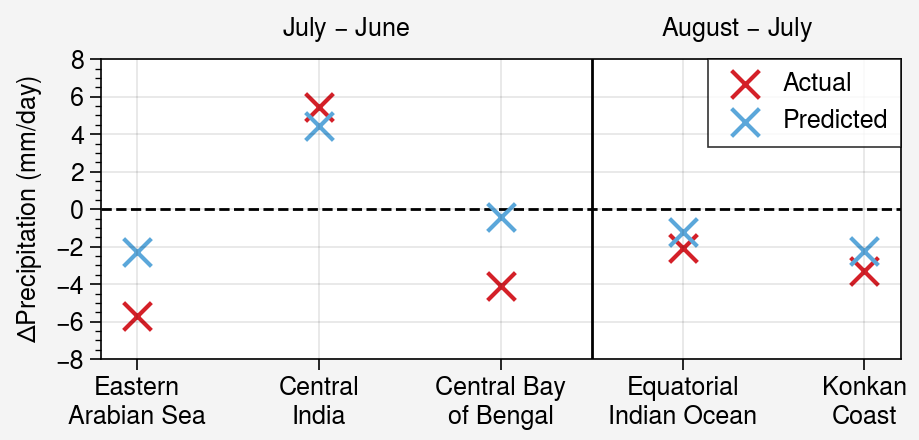

In [52]:
regions = ['Eastern\nArabian Sea','Central\nIndia','Central Bay\nof Bengal','Equatorial\nIndian Ocean','Konkan\nCoast']
fig,ax  = pplt.subplots(refheight=1.5,refwidth=4)
ax.format(ylabel='$\Delta$Precipitation (mm/day)',ylim=(-8,8),yticks=2)
ax.text(x=1.15,y=ax.get_ylim()[1]+0.8,s='July $-$ June',**titlekwargs)
ax.text(x=3.3,y=ax.get_ylim()[1]+0.8,s='August $-$ July',**titlekwargs)
ax.axvline(x=2.5,**linekwargs)
ax.axhline(y=0,linestyle='--',**linekwargs)
ax.scatter(regions,realprdiffs,label='Actual',**realprkwargs)
ax.scatter(regions,predprdiffs,label='Predicted',**predprkwargs)
ax.legend(loc='ur',ncols=1)
pplt.show()
fig.save(f'{SAVEDIR}/fig_4.png',dpi=900)

In [59]:
for region,predprdiff,realprdiff in zip(REGIONS.keys(),predprdiffs,realprdiffs):
    print(f'{region}:')
    print(f'- Real P difference: {realprdiff:.1f} mm/day')
    print(f'- Predicted P difference: {predprdiff:.1f} mm/day')
    percenterror = ((predprdiff-realprdiff)/realprdiff)*100
    print(f'- Percent error: {percenterror:.1f}%')

Eastern Arabian Sea:
- Real P difference: -5.7 mm/day
- Predicted P difference: -2.3 mm/day
- Percent error: -59.5%
Central India:
- Real P difference: 5.4 mm/day
- Predicted P difference: 4.4 mm/day
- Percent error: -18.2%
Central Bay of Bengal:
- Real P difference: -4.1 mm/day
- Predicted P difference: -0.4 mm/day
- Percent error: -89.6%
Equatorial Indian Ocean:
- Real P difference: -2.1 mm/day
- Predicted P difference: -1.2 mm/day
- Percent error: -40.5%
Konkan Coast:
- Real P difference: -3.3 mm/day
- Predicted P difference: -2.2 mm/day
- Percent error: -32.7%
